In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive'

 checkpoints	    Efficient+MEdbert.ipynb   GP2
'Colab Notebooks'   GP1			      Untitled0.ipynb


New Architecture (Intermediate Fusion with Cross-Modal Attention)
Now everything is part of a single neural network that learns joint image + text representations:

🖼️ Image Encoder: EfficientNet (backbone only, up to penultimate layer) → produces image_features vector.

📝 Text Encoder: Linear projection of TF-IDF vectors to match image feature size → text_features.

🔗 Cross-Modal Attention:

The image features are used as queries.

The text features are used as keys and values.

Attention weights determine how the model focuses on text, given visual context.

🧠 Fusion: The attended features are concatenated with original image features and passed through a classifier head.

 image attends to text — meaning:

Image features are the queries, and text features are the keys and values in the attention mechanism

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score
import json
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [ ]:
class MedPixJSONDataset(torch.utils.data.Dataset):
    def __init__(self, json_path, image_dir, label_mapping, transform=None):
        with open(json_path, 'r') as f:
            raw_data = json.load(f)

        self.entries = []
        self.transform = transform
        self.image_dir = image_dir
        self.label_mapping = label_mapping

        for item in raw_data:
            images = []
            mri = item.get("MRI", [])
            ct = item.get("TAC", [])
            if mri: images.append(mri[0])
            if ct: images.append(ct[0])
            if not images: continue

            case_data = item.get("Case", {})
            entry = {
                "images": images,
                "text": " ".join([
                    str(case_data.get("Title", "")),
                    str(case_data.get("History", "")),
                    str(case_data.get("Differential Diagnosis", "")),
                    str(item.get("Location", ""))
                ]),
                "label": label_mapping.get(item["Class/Label"], -1)
            }
            self.entries.append(entry)

    def __len__(self): return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        loaded_images = []
        for img_file in entry["images"]:
            path = os.path.join(self.image_dir, f"{img_file}.png")
            image = Image.open(path).convert("RGB")
            if self.transform: image = self.transform(image)
            loaded_images.append(image)
        return loaded_images[0], entry["text"], entry["label"]

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super(ImageEncoder, self).__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(1280, embed_dim)

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(-1).squeeze(-1)
        return self.fc(x)

class TextEncoder(nn.Module):
    def __init__(self, input_dim=3000, embed_dim=128):
        super(TextEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, embed_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class CrossModalAttention(nn.Module):
    def __init__(self, embed_dim=128):
        super(CrossModalAttention, self).__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)

    def forward(self, text_feat, image_feat):
        text_feat = text_feat.unsqueeze(1)
        image_feat = image_feat.unsqueeze(1)
        out, _ = self.attn(text_feat, image_feat, image_feat)
        return out.squeeze(1)

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self, text_input_dim, embed_dim=128, num_classes=12):
        super(MultimodalClassifier, self).__init__()
        self.text_encoder = TextEncoder(text_input_dim, embed_dim)
        self.image_encoder = ImageEncoder(embed_dim)
        self.cross_attention = CrossModalAttention(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, text):
        image_feat = self.image_encoder(image)
        text_feat = self.text_encoder(text)
        fused = self.cross_attention(text_feat, image_feat)
        return self.classifier(fused)


In [ ]:
label_mapping = {
    "Congenital & Genetic": 0,
    "Trauma & Physical Injuries": 1,
    "Vascular & Circulatory": 2,
    "Infections": 3,
    "Neoplasm - Benign & Sarcoma": 4,
    "Neoplasm - Carcinoma": 5,
    "Neoplasm - Other Malignant": 6,
    "Inflammatory & Autoimmune": 7,
    "Metabolic & Endocrine": 8,
    "Cysts & Degenerative Conditions": 9,
    "Obstruction & Structural Abnormalities": 10,
    "Miscellaneous Conditions": 11
}
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = MedPixJSONDataset("/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Image_2_Augmented.json", "/content/drive/MyDrive/GP2/6_After_2-Image_Augmentation/Images_After_2-Image_Augmentation", label_mapping, transform)

texts = [entry["text"] for entry in dataset.entries]
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_text = vectorizer.fit_transform(texts).toarray()

X_images, y_labels = [], []
for i in tqdm(range(len(dataset))):
    image, _, label = dataset[i]
    X_images.append(image)
    y_labels.append(label)

X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    X_images, X_text, y_labels, test_size=0.2, stratify=y_labels, random_state=42)

100%|██████████| 7098/7098 [1:42:48<00:00,  1.15it/s]


In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.stack(X_img_train),
    torch.tensor(X_txt_train, dtype=torch.float32),
    torch.tensor(y_train)
)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

model = MultimodalClassifier(text_input_dim=3000).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    total_loss = 0
    for img_batch, txt_batch, lbl_batch in train_loader:
        img_batch = img_batch.cuda()
        txt_batch = txt_batch.cuda()
        lbl_batch = lbl_batch.cuda()

        optimizer.zero_grad()
        outputs = model(img_batch, txt_batch)
        loss = criterion(outputs, lbl_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s]


Epoch 1, Loss: 304.2147
Epoch 2, Loss: 169.8388
Epoch 3, Loss: 107.0632
Epoch 4, Loss: 73.3639
Epoch 5, Loss: 59.1312


✅ Accuracy: 0.9338028169014084
✅ Precision: 0.9264204028044443
✅ F1: 0.9246171324415394

📊 Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.78      0.89      0.83       106
            Trauma & Physical Injuries       0.96      1.00      0.98       142
                Vascular & Circulatory       0.99      0.94      0.96       108
                            Infections       0.94      1.00      0.97        98
           Neoplasm - Benign & Sarcoma       0.95      1.00      0.98       137
                  Neoplasm - Carcinoma       0.98      1.00      0.99       130
            Neoplasm - Other Malignant       0.86      0.79      0.83       121
             Inflammatory & Autoimmune       0.97      1.00      0.98       130
                 Metabolic & Endocrine       0.99      1.00      1.00       122
       Cysts & Degenerative Conditions       0.97      1.00      0.99       115
Obstr

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


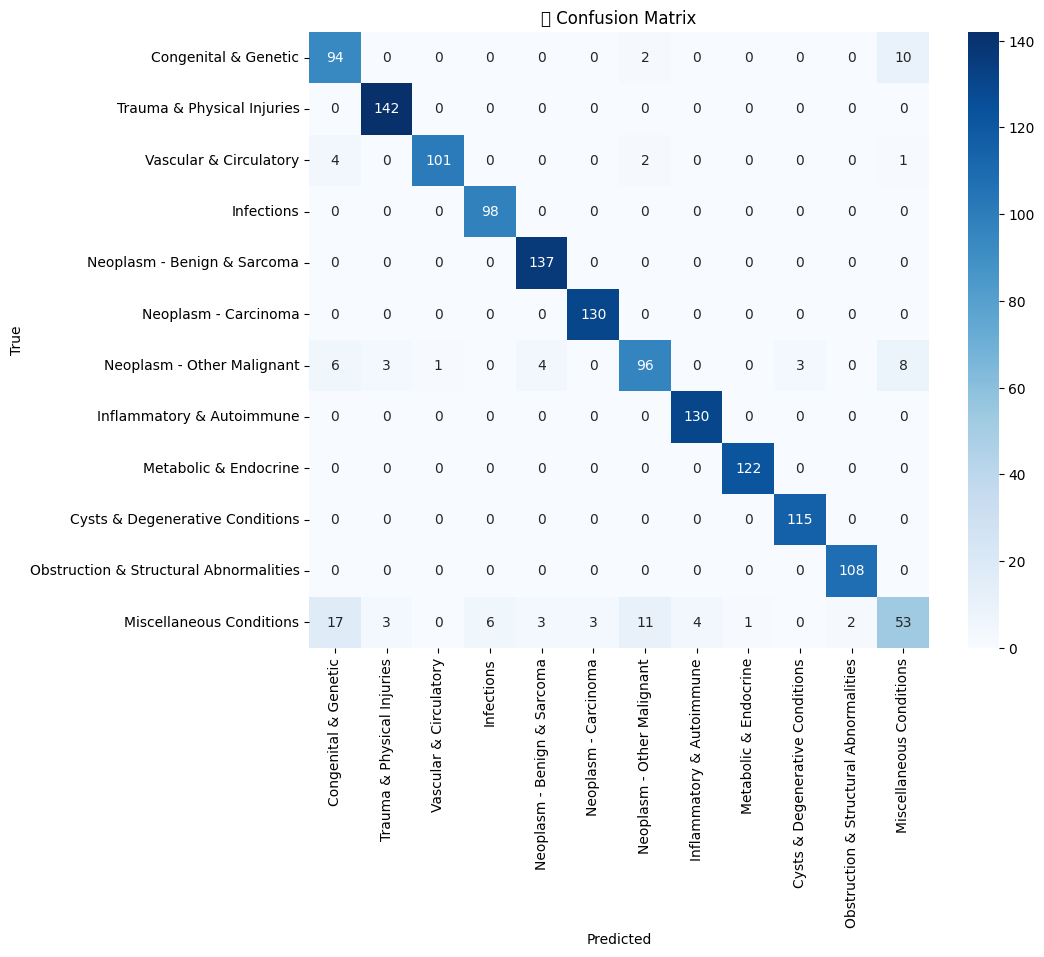


🔬 Sensitivity per class:
Congenital & Genetic: 0.89
Trauma & Physical Injuries: 1.00
Vascular & Circulatory: 0.94
Infections: 1.00
Neoplasm - Benign & Sarcoma: 1.00
Neoplasm - Carcinoma: 1.00
Neoplasm - Other Malignant: 0.79
Inflammatory & Autoimmune: 1.00
Metabolic & Endocrine: 1.00
Cysts & Degenerative Conditions: 1.00
Obstruction & Structural Abnormalities: 1.00
Miscellaneous Conditions: 0.51

🛡️ Specificity per class:
Congenital & Genetic: 0.98
Trauma & Physical Injuries: 1.00
Vascular & Circulatory: 1.00
Infections: 1.00
Neoplasm - Benign & Sarcoma: 0.99
Neoplasm - Carcinoma: 1.00
Neoplasm - Other Malignant: 0.99
Inflammatory & Autoimmune: 1.00
Metabolic & Endocrine: 1.00
Cysts & Degenerative Conditions: 1.00
Obstruction & Structural Abnormalities: 1.00
Miscellaneous Conditions: 0.99


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


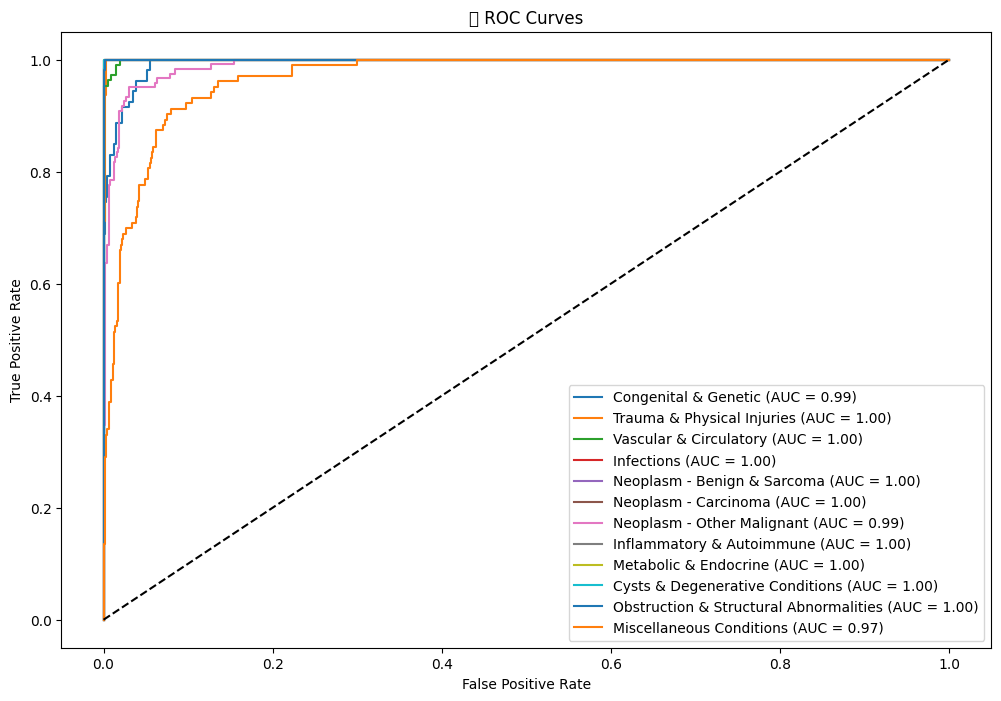

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_dataset = torch.utils.data.TensorDataset(
    torch.stack(X_img_test),
    torch.tensor(X_txt_test, dtype=torch.float32),
    torch.tensor(y_test)
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

model.eval()
preds, probs, labels = [], [], []
with torch.no_grad():
    for img_batch, txt_batch, lbl_batch in test_loader:
        img_batch = img_batch.cuda()
        txt_batch = txt_batch.cuda()
        outputs = model(img_batch, txt_batch)
        soft = torch.softmax(outputs, dim=1)
        preds.extend(torch.argmax(soft, dim=1).cpu().numpy())
        probs.extend(soft.cpu().numpy())
        labels.extend(lbl_batch.numpy())

print("✅ Accuracy:", accuracy_score(labels, preds))
print("✅ Precision:", precision_score(labels, preds, average='macro'))
print("✅ F1:", f1_score(labels, preds, average='macro'))
print("\n📊 Classification Report:")
print(classification_report(labels, preds, target_names=label_mapping.keys()))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🧩 Confusion Matrix")
plt.show()

sensitivities, specificities = [], []
num_classes = len(label_mapping)
for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FN - FP
    sens = TP / (TP + FN) if (TP + FN) else 0
    spec = TN / (TN + FP) if (TN + FP) else 0
    sensitivities.append(sens)
    specificities.append(spec)

print("\n🔬 Sensitivity per class:")
for i, label in enumerate(label_mapping.keys()):
    print(f"{label}: {sensitivities[i]:.2f}")

print("\n🛡️ Specificity per class:")
for i, label in enumerate(label_mapping.keys()):
    print(f"{label}: {specificities[i]:.2f}")

y_true_bin = label_binarize(labels, classes=list(range(num_classes)))
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], np.array(probs)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{list(label_mapping.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("📈 ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
